# Project 3: Classifying subreddit posts

- [Part 1: Data collection and data cleaning](https://nbviewer.jupyter.org/github/zixinlee/GA-data-science/blob/master/Reddit-classification/1-Reddit-data-collection.ipynb)
- Part 2: EDA and modelling (current)
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve

In [2]:
# import cleaned dataset from part 1
df = pd.read_csv('datasets/women_combined_clean.csv')

In [3]:
df.sample(10)

,subreddit,ups,created,num_comments,fulltext,is_askwomenover30
701,askwomen,56,1.598218e+09,63,tv series character exact personality looks th...,0
1331,askwomenover30,2,1.597753e+09,2,example someone victim success situation perso...,1
498,askwomen,1,1.598585e+09,5,book inspired recently either inspired sense s...,0
1246,askwomenover30,9,1.598230e+09,9,become person whos fashion im definitely one p...,1
968,askwomen,5,1.597661e+09,19,women hormonal acne aside trying combat treatm...,0
494,askwomen,6,1.598588e+09,31,goto song make feel badass,0
901,askwomen,50,1.597795e+09,125,obscure piece entertainment unable find copy o...,0
88,askwomen,41,1.599361e+09,68,days kind fun things like,0
1491,askwomenover30,3,1.597006e+09,28,kids give life meaning grew conservative cultu...,1
1674,askwomenover30,260,1.595983e+09,268,let talk vasectomies friend considering perman...,1


In [4]:
# create column for word count of `fulltext` column
df['text_length'] = [len(text.split()) for text in df['fulltext']]

In [5]:
df.tail()

,subreddit,ups,created,num_comments,fulltext,is_askwomenover30,text_length
1962,askwomenover30,6,1.594175e+09,19,something annoys bothers upsets wish would go ...,1,10
1963,askwomenover30,10,1.594170e+09,13,looking pity party im one wrong could use hope...,1,354
1964,askwomenover30,6,1.594169e+09,15,celebrate christmas july dont know common know...,1,10
1965,askwomenover30,13,1.594167e+09,5,partner f returned work high risk job despite ...,1,267
1966,askwomenover30,129,1.594165e+09,223,would rather gifted weekly cleaning service le...,1,41


In [6]:
# convert `created` to conventional datetime format
# `created` is in unix epoch time, so we have to pass in the unit parameter 's'
df['created'] = pd.to_datetime(df['created'], unit='s')

In [7]:
df.head()

,subreddit,ups,created,num_comments,fulltext,is_askwomenover30,text_length
0,askwomen,1,2020-09-07 16:04:17,11,whats difference worst best relationship,0,5
1,askwomen,0,2020-09-07 15:43:45,6,would welcome queen elsa princess anna house h...,0,9
2,askwomen,5,2020-09-07 15:29:59,4,women lax uninvolved parents impacted life adult,0,7
3,askwomen,6,2020-09-07 13:56:05,36,generalization gender irks,0,3
4,askwomen,2,2020-09-07 12:06:44,10,much exercise dog get day kind dog,0,7


In [8]:
# subset dataframe for r/AskWomen
df_askwomen = df.loc[df['subreddit'] == 'askwomen']

In [9]:
# subset dataframe for r/AskWomenOver30
df_askwomen30 = df.loc[df['subreddit'] == 'askwomenover30']

## Comparing length of posts

Text(0.5, 0, 'Word Count')

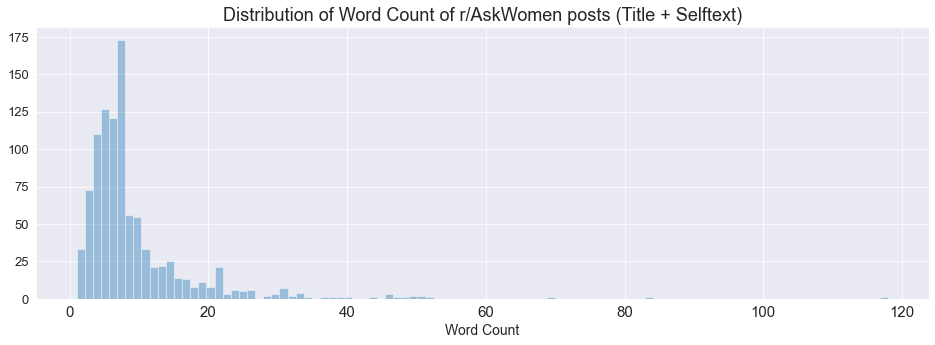

In [91]:
plt.figure(figsize=(16,5))
sns.distplot(df_askwomen['text_length'], kde=False, bins=100)
# plt.axvline(np.median(df_askwomen['text_length']), color = "red", label='median')
# plt.axvline(np.mean(df_askwomen['text_length']), color = "blue", label='mean')
plt.title("Distribution of Word Count of r/AskWomen posts (Title + Selftext)", size = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.xlabel('Word Count', fontsize=14)
# plt.legend();

Text(0.5, 0, 'Word Count')

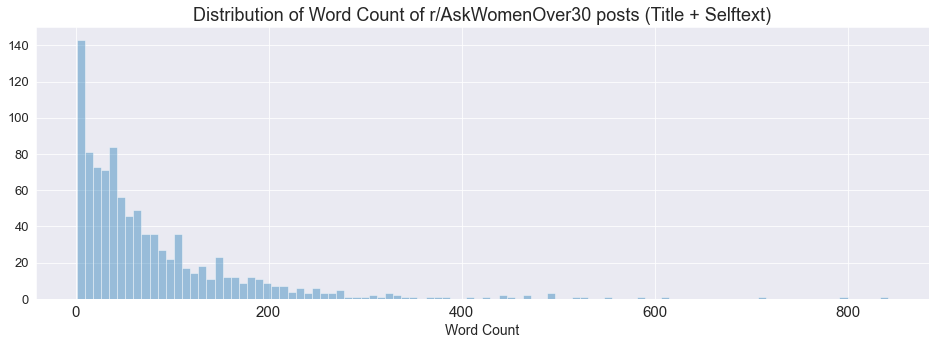

In [92]:
plt.figure(figsize=(16,5))
sns.distplot(df_askwomen30['text_length'], kde=False, bins=100)
# plt.axvline(np.median(df_askwomen30['text_length']), color = "red", label='median')
# plt.axvline(np.mean(df_askwomen30['text_length']), color = "blue", label='mean')
plt.title("Distribution of Word Count of r/AskWomenOver30 posts (Title + Selftext)", size = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.xlabel('Word Count', fontsize=14)
# plt.legend();

## Comparing time span of posts

In [12]:
# r/AskWomen
earliest_post = df_askwomen['created'].min()
latest_post = df_askwomen['created'].max()
time_span = latest_post - earliest_post
print(f'Our posts from r/AskWomen are dated from [{earliest_post}] to [{latest_post}].')
print(f'Time span: {time_span}')

Our posts from r/AskWomen are dated from [2020-08-17 06:18:13] to [2020-09-07 16:04:17].
Time span: 21 days 09:46:04


In [13]:
# r/AskWomenOver30
earliest_post = df_askwomen30['created'].min()
latest_post = df_askwomen30['created'].max()
time_span = latest_post - earliest_post
print(f'Our posts from r/AskWomenOver30 are dated from [{earliest_post}] to [{latest_post}].')
print(f'Time span: {time_span}')

Our posts from r/AskWomenOver30 are dated from [2020-07-07 23:44:08] to [2020-09-07 16:55:07].
Time span: 61 days 17:10:59


r/AskWomen (1.7m members) is much more active than r/AskWomenOver30 (79.6k members), so it makes sense that the posts scraped from r/AskWomen span a shorter timeframe compared to r/AskWomenOver30.

## Comparing number of comments

In [14]:
# average number of comments per post in each subreddit
df.groupby('subreddit').agg({'num_comments': 'mean'})

,num_comments
subreddit,
askwomen,57.043833
askwomenover30,34.308316


Posts on r/AskWomen have on average 57 comments per post, which works out to about 66% higher than r/AskWomenOver30 which has 34 comments per post. This is unsurprising given that r/AskWomen (1.7m) has substantially more members than r/AskWomenOver30 (79.6k).

In [15]:
(57-34.3)/34.3

0.6618075801749272

## Visualise the most common words

In [16]:
# define a function to retrieve the top n words in a corpus based on frequency count
def top_n_words(corpus, n=None):
    cv = CountVectorizer()
    
    # create document-term matrix
    data_cv = cv.fit_transform(corpus)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    
    # get the top n words
    top_n_words = pd.DataFrame(data_dtm.sum().sort_values(ascending=False).reset_index().head(n))
    top_n_words.columns = ['word', 'count']
    
    return top_n_words

In [17]:
# get the top 20 most frequently used words in r/AskWomen
top_20_askwomen = top_n_words(df_askwomen.fulltext, 20)

In [18]:
# get the top 20 most frequently used words in r/AskWomenOver30
top_20_askwomen30 = top_n_words(df_askwomen30.fulltext, 20)

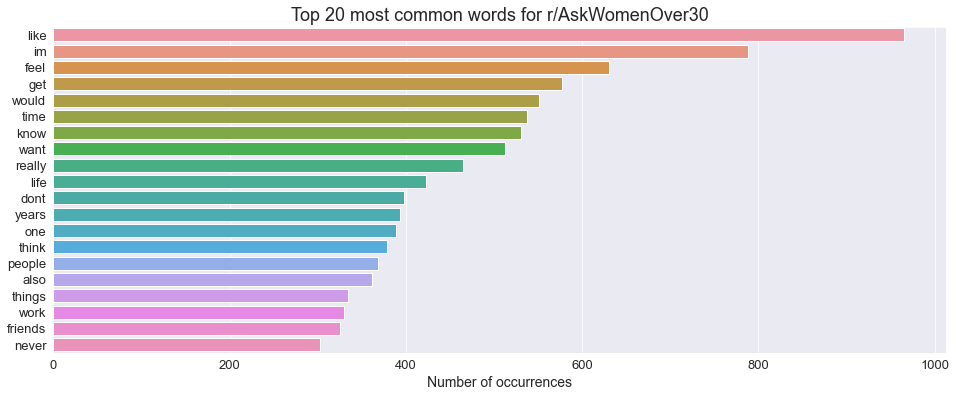

In [19]:
# bar plot of most common words in r/AskWomenOver30
plt.figure(figsize=(16,6))
sns.barplot(x=top_20_askwomen30['count'], y=top_20_askwomen30['word'])
plt.title('Top 20 most common words for r/AskWomenOver30', fontsize=18)
plt.xlabel('Number of occurrences', fontsize=14)
plt.xticks(size=13)
plt.ylabel(None)
plt.yticks(size=13);

(-0.5, 2999.5, 1999.5, -0.5)

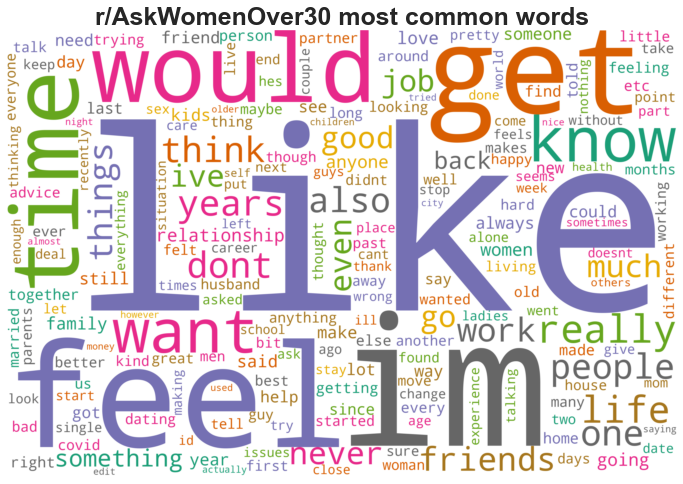

In [20]:
# create a word cloud for the most common words in r/AskWomenOver30
# text that we want to make a wordcloud for
cv = CountVectorizer()
text = pd.DataFrame(cv.fit_transform(df_askwomen30.fulltext).toarray(), columns=cv.get_feature_names()).sum().sort_values(ascending=False)

# generate a wordcloud
wordcloud = WordCloud(width=3000, height=2000, 
                      background_color='white', colormap='Dark2',
                      collocations=False,
                      max_words=200,
                      ).generate_from_frequencies(text)
plt.figure(figsize=(12,10))
plt.title('r/AskWomenOver30 most common words', fontsize=25, weight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 

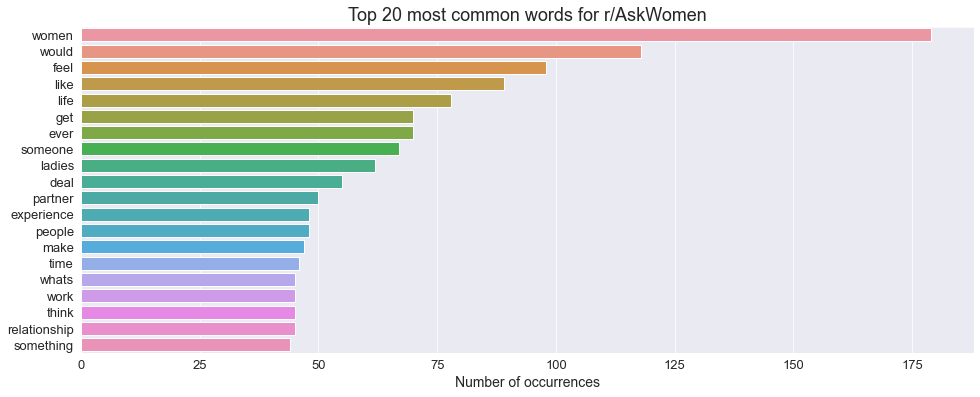

In [21]:
# bar plot of most common words in r/AskWomen
plt.figure(figsize=(16,6))
sns.barplot(x=top_20_askwomen['count'], y=top_20_askwomen['word'])
plt.title('Top 20 most common words for r/AskWomen', fontsize=18)
plt.xlabel('Number of occurrences', fontsize=14)
plt.xticks(size=13)
plt.ylabel(None)
plt.yticks(size=13);

(-0.5, 2999.5, 1999.5, -0.5)

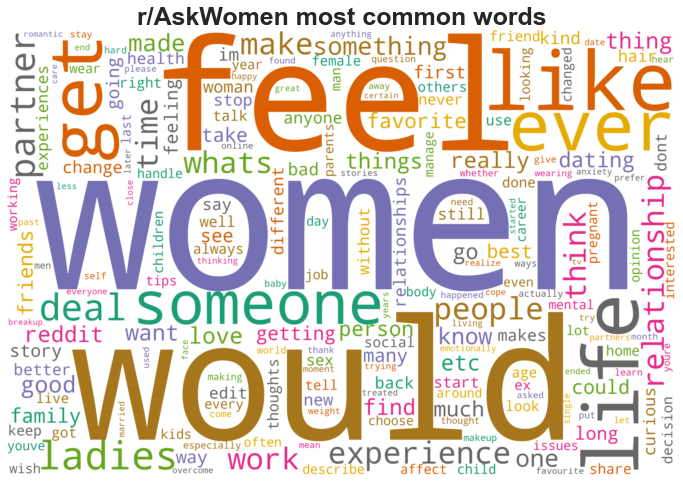

In [22]:
# create word cloud for r/AskWomen most common words

# text that we want to make a wordcloud for
cv = CountVectorizer()
text = pd.DataFrame(cv.fit_transform(df_askwomen.fulltext).toarray(), columns=cv.get_feature_names()).sum().sort_values(ascending=False)
 
# generate wordcloud
wordcloud = WordCloud(width=3000, height=2000, 
                    background_color='white', colormap='Dark2',
                      collocations=False,
                      max_words=200,
                      ).generate_from_frequencies(text)
plt.figure(figsize=(12,10))
plt.title('r/AskWomen most common words', fontsize=25, weight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 

## Include words common to both subreddits in stopwords

In the first notebook where I have performed data cleaning, I have already removed the stop words that are defined by NLTK. However, since our EDA shows us that there are a few common words that occur in both subreddits, I will create a list of customised stopwords that will be removed from the text. 

Subsequently, I will normalize the text through lemmatization to ensure that we do not have multiple forms of similar words. 

Text normalization can be done through lemmatization or stemming, but I am opting to not use stemming because it is more indiscriminate in cutting off the end of a word to obtain a shorter word, even if that form doesn't have any meaning. On the other hand, lemmatization is more sophisticated and converts a word into its meaningful base form, so we will always get a valid dictionary word.

Lemmatization is more computationally intensive than stemming, but as I am not working with a large dataset here, performance is not a big concern. 

## Remove stopwords (round 2) + Lemmatize words

In [23]:
# get list of NLTK stopwords
stopwords = stopwords.words('english')

# list of new stopwords to drop
new_stopwords = ['like', 'im', 'ive', 'would', 'also', 'get', 'life', 'women', 'woman']

# append new stopwords to list of default stopwords
stopwords.extend(new_stopwords)

In [24]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    tokens = [w for w in tokens if w not in set(stopwords)] # remove stopwords from tokens
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)

In [25]:
df['fulltext'] = df.fulltext.apply(lemmatize_text)

## Set up X and y, and split into training and test data

In [26]:
X = df['fulltext']
y = df['is_askwomenover30']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Establishing baseline accuracy

The baseline accuracy will be the percentage of positive class samples (r/AskWomenOver30) in our dataset. This will be the benchmark by which we will measure a model's performance. 

For our case, the classifier should have an accuracy greater than 50.1%, otherwise we will be better off predicting all samples as the positive class and be correct half the time.

In [27]:
y_train.value_counts(normalize=True)

1    0.501453
0    0.498547
Name: is_askwomenover30, dtype: float64

## Modelling

As a final data preparation step prior to modelling, I will utilise sklearn's CountVectorizer and TfidfVectorizer to transform all the posts into numerical vectors that can be fed into our machine learning models.

Unlike what their names suggest, the CountVectorizer and TfidfVectorizer are actually performing both tokenization and vectorization under the hood. 

_Tokenization_ refers to the process of splitting a document (in this case, a post) into smaller pieces called "tokens". These tokens can be individual words, bi-grams, or tri-grams. _Vectorization_ is the process of characterizing these tokens using a numerical measure. The _Count Vectorizer_ will simply count the frequency of every word and give every word an equal weightage. On the other hand, the _TFIDF Vectorizer_ gives different weights to words by evaluating the relevance of a word to a document with respect to the corpus. The fewer documents in which a term occurs, the more significant it likely is to be to the documents it does occur in. 

The 2 vectorizers will be tested in combination with each of the 3 classification models below for a more comprehensive comparison.

1. Logistic Regression
2. Multinomial Naive Bayes
3. Support Vector Machine/Classifier

I will chain the vectorization and modelling steps together in a pipeline set-up, which will be fed into GridSearchCV so that hyperparameter tuning can be done to find the best hyperparameter combination for each model.




### Evaluation metrics


To evaluate our classifiers, I will make use of the confusion matrix, which differentiates between the true classes and the classes predicted by the model. 

Each sample in the test set, which has an actual class label as well as the class predicted by the classifier, will fall into 1 of these 4 categories:


1. **True Positive (TP)** - positive instances correctly classified as positive
2. **True Negative (TN)** - negative instances correctly classified as negative
3. **False Positive (FP)** - negative instances wrongly classified as positive
4. **False Negative (FN)** - positive instances wrongly classified as negative


With these counts, we can describe various other evaluation matrics:

- **Accuracy** – percentage of correct predictions out of all predictions made.
    - % of r/AskWomen and r/AskWomenOver30 predictions that actually belong to those subreddits.
    
\begin{eqnarray*}
\text{Accuracy} = \frac{\text{Correct predictions}}{\text{All predictions}} = \frac{\text{TP + TN}}{\text{TP + FP + TN + FN}}
\end{eqnarray*}





- **Precision** – Percentage of correctly predicted positive observations out of the total predicted positive observations.

    - % of r/AskWomenOver30 predictions that actually belong to r/AskWomenOver30.

\begin{eqnarray*}
\text{Precision} = \frac{\text{True positives}}{\text{All positive predictions}} = \frac{\text{TP}}{\text{TP + FP}}
\end{eqnarray*}




- **Sensitivity / Recall** – percentage of correctly predicted positive observations to the all observations in actual class

    - % of all r/AskWomenOver30 posts that were correctly predicted to belong to r/AskWomenOver30.

\begin{eqnarray*}
\text{Sensitivity / Recall} = \frac{\text{True positives}}{\text{All positives}} = \frac{\text{TP}}{\text{TP + FN}}
\end{eqnarray*}


- **AUC score**

    - For each model we will also calculate an AUC (area under the ROC curve) score, which is a good general summary statistic of the predictiveness of a classifier. The AUC score varies from 0.5 to 1. A value of 0.5 corresponds to randomness (the classifier cannot distinguish between the positive and negative class). The closer the AUC score is to 1, the better the classifier is at distinguishing between classes. 

In [28]:
# define functions for model performance

def precision(y_test, y_test_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    precision = tp / (tp + fp)
    return precision

def recall(y_test, y_test_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    recall = tp / (tp + fn)
    return recall
    
def accuracy(model, X_train, X_test, y_train, y_test):
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    print(f'Training accuracy: {round(train_accuracy, 5)}')
    print(f'Testing accuracy: {round(test_accuracy, 5)}')

### Logistic Regression

**Count Vectorizer**

In [29]:
# set up pipeline
cvlr_pipe = Pipeline([
    ('cvec', CountVectorizer()), 
    ('logreg', LogisticRegression())
])

# parameters for grid search 
params_cvlr = {
    'cvec__stop_words': ['english'],
    'cvec__max_features': [1000, 1100, 1200],
    'cvec__min_df': [2, 4],
    'cvec__max_df': [.8,.85],
    'cvec__ngram_range': [(1,1), (1,2)],
}

# instantiating the grid search
cvlr_gs = GridSearchCV(cvlr_pipe, param_grid=params_cvlr , cv=5)

# fitting training data to the model
cvlr_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [1000, 1100, 1200],
                         'cvec__min_df': [2, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english']})

In [30]:
# parameters of the best model
cvlr_gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 1000,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english'}

In [31]:
cvlr_preds = cvlr_gs.predict(X_test)

In [32]:
# check model accuracy on train and test data
accuracy(cvlr_gs, X_train, X_test, y_train, y_test)

Training accuracy: 0.92878
Testing accuracy: 0.80203


#### TFIDF Vectorizer

In [33]:
tfidf = TfidfVectorizer()

In [34]:
tfidf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [35]:
tflr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('logreg', LogisticRegression())
])

# parameters for gridsearch 
params_tflr = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [2000, 2500, 3000],
    'tfidf__min_df': [2],
    'tfidf__max_df': [.8,.85],
    'tfidf__ngram_range': [(1,2), (1,3)],
}

# instantiate gridsearch 
tflr_gs = GridSearchCV(tflr_pipe, param_grid = params_tflr , cv = 5)

# fitting training data to the model
tflr_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'tfidf__max_df': [0.8, 0.85],
                         'tfidf__max_features': [2000, 2500, 3000],
                         'tfidf__min_df': [2],
                         'tfidf__ngram_range': [(1, 2), (1, 3)],
                         'tfidf__stop_words': [None, 'english']})

In [36]:
tflr_gs.best_params_

{'tfidf__max_df': 0.8,
 'tfidf__max_features': 2500,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': None}

In [37]:
tflr_preds = tflr_gs.predict(X_test)

In [38]:
accuracy(tflr_gs, X_train, X_test, y_train, y_test)

Training accuracy: 0.91061
Testing accuracy: 0.80203


## Multinomial Naive Bayes

#### Count Vectorizer

In [39]:
nb = MultinomialNB()

In [40]:
cvnb_pipe = Pipeline([
    ('cvec', CountVectorizer()), 
    ('nb', MultinomialNB())
])

# parameters for grid search 
params_cvnb = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [1500, 2000],
    'cvec__min_df': [6, 8],
    'cvec__max_df': [.8, .85],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
}

# gridsearch 
cvnb_gs = GridSearchCV(cvnb_pipe, param_grid = params_cvnb , cv = 5)

# fit model to data
cvnb_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.8, 0.85],
                         'cvec__max_features': [1500, 2000],
                         'cvec__min_df': [6, 8],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [None, 'english']})

In [41]:
cvnb_gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 1500,
 'cvec__min_df': 8,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [42]:
cvnb_preds = cvnb_gs.predict(X_test)

In [43]:
accuracy(cvnb_gs, X_train, X_test, y_train, y_test)

Training accuracy: 0.82776
Testing accuracy: 0.71066


#### TFIDF Vectorizer 

In [44]:
tfnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('nb', MultinomialNB())
])

# parameters for grid search 
params_tfnb = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [1500, 2000],
    'tfidf__min_df': [4, 6],
    'tfidf__max_df': [.8, .85],
    'tfidf__ngram_range': [(1,2), (1,3)],
}

# instatiate gridsearch 
tfnb_gs = GridSearchCV(tfnb_pipe, param_grid = params_tfnb , cv = 5)

In [45]:
tfnb_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tfidf__max_df': [0.8, 0.85],
                         'tfidf__max_features': [1500, 2000],
                         'tfidf__min_df': [4, 6],
                         'tfidf__ngram_range': [(1, 2), (1, 3)],
                         'tfidf__stop_words': [None, 'english']})

In [46]:
tfnb_gs.best_params_

{'tfidf__max_df': 0.8,
 'tfidf__max_features': 1500,
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [47]:
accuracy(tfnb_gs, X_train, X_test, y_train, y_test)

Training accuracy: 0.86628
Testing accuracy: 0.69205


In [48]:
tfnb_preds = tfnb_gs.predict(X_test)

## Support Vector Classifier

#### Count Vectorizer

In [49]:
# Setting up the pipeline
cvsvc_pipe = Pipeline([("cvec", CountVectorizer()), 
                         ("svc", SVC(probability=True))])

# Setting CVEC and pipe hyperparameters
params_cvsvc = {"cvec__max_features": [1500, 2000, 2500], 
                "cvec__ngram_range" : [(1,1), (1,2)], 
                "svc__C"            : [1.0, 0.8],
                # tried kernels 'linear', 'poly', 'rbf', 'sigmoid' -- 'linear' gave the best results    
                "svc__kernel"       : ['linear'],
                "svc__gamma"        : ["auto"]}
                    
# Instantiate the grid search
cvsvc_gs = GridSearchCV(cvsvc_pipe, param_grid = params_cvsvc, cv=5)

# Fit the model to the training data
cvsvc_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svc', SVC(probability=True))]),
             param_grid={'cvec__max_features': [1500, 2000, 2500],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'svc__C': [1.0, 0.8], 'svc__gamma': ['auto'],
                         'svc__kernel': ['linear']})

In [50]:
cvsvc_gs.best_params_

{'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 1),
 'svc__C': 0.8,
 'svc__gamma': 'auto',
 'svc__kernel': 'linear'}

In [51]:
accuracy(cvsvc_gs, X_train, X_test, y_train, y_test)

Training accuracy: 0.96802
Testing accuracy: 0.77157


In [52]:
cvsvc_preds = cvsvc_gs.predict(X_test)

#### TFIDF Vectorizer

In [53]:
tvec =  TfidfVectorizer()

In [54]:
tvec.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [55]:
# Setting up the pipeline
tfsvc_pipe = Pipeline([("tvec", TfidfVectorizer()), 
                         ("svc", SVC(probability=True))])

# Setting TFIDF and pipe hyperparameters

params_tfsvc = {"tvec__max_features": [1000, 1500, 2000], 
                "tvec__ngram_range" : [(1,1)], 
                "svc__C"            : [0.5, 0.4, 0.2],
                # tried kernels 'linear', 'poly', 'rbf', 'sigmoid' -- 'linear' gave the best results
                "svc__kernel"       : ['linear'],
                "svc__gamma"        : ["auto"]}
                    
# Instantiating the grid search
tfsvc_gs = GridSearchCV(tfsvc_pipe, param_grid = params_tfsvc, cv=5)

# Fitting the model to the training data
tfsvc_gs.fit(X_train, y_train);

In [56]:
tfsvc_gs.best_params_

{'svc__C': 0.4,
 'svc__gamma': 'auto',
 'svc__kernel': 'linear',
 'tvec__max_features': 1000,
 'tvec__ngram_range': (1, 1)}

In [57]:
accuracy(tfsvc_gs, X_train, X_test, y_train, y_test)

Training accuracy: 0.87282
Testing accuracy: 0.79019


In [58]:
tfsvc_preds = tfsvc_gs.predict(X_test)

## Model evaluation

For easy comparison, I will summarise in a dataframe the evaluation metrics for all models.

In [59]:
cvlr_gs.predict_proba(X_test)[:, 1]

array([0.99553818, 0.83164986, 1.        , 0.1441389 , 0.91025216,
       0.96077922, 0.35946691, 0.17839719, 0.23006662, 0.78830959,
       0.15089223, 0.15397423, 0.94693613, 0.99665041, 0.98655839,
       0.84499243, 0.13433026, 0.18623543, 0.29308489, 0.99999692,
       0.99836106, 0.13653463, 0.36250887, 0.44032997, 0.65468209,
       0.15258922, 0.18879397, 0.98915406, 0.6936445 , 0.02083297,
       0.08316732, 1.        , 0.46196806, 0.16203449, 0.8470692 ,
       0.99989574, 0.99425307, 0.11169286, 0.14555868, 0.37141467,
       0.74228831, 0.08278906, 0.83067928, 0.99403341, 0.95358337,
       0.36306661, 0.24255936, 0.19613113, 0.12822636, 0.99999888,
       0.34009939, 0.10211585, 0.98317832, 0.99967596, 0.24983668,
       0.99999671, 0.9999979 , 0.17657228, 1.        , 0.32351844,
       0.99841939, 0.31036561, 0.64004452, 0.10267327, 0.25852167,
       0.50656185, 0.0919777 , 0.59541156, 0.30767397, 1.        ,
       0.99954248, 1.        , 0.99595222, 0.13694014, 0.35313

In [60]:
# Summarise the evaluation metrics of all models

# Model accuracy score with test data
cvlr_train_acc = cvlr_gs.score(X_train, y_train)
tflr_train_acc = tflr_gs.score(X_train, y_train)
cvnb_train_acc = cvnb_gs.score(X_train, y_train)
tfnb_train_acc = tfnb_gs.score(X_train, y_train)
cvsvc_train_acc = cvsvc_gs.score(X_train, y_train)
tfsvc_train_acc = tfsvc_gs.score(X_train, y_train)

# store the accuracy scores in a list
train_acc_scores = [
    cvlr_train_acc,
    tflr_train_acc,
    cvnb_train_acc,
    tfnb_train_acc,
    cvsvc_train_acc,
    tfsvc_train_acc
]

# Model accuracy score with test data
cvlr_test_acc = cvlr_gs.score(X_test, y_test)
tflr_test_acc = tflr_gs.score(X_test, y_test)
cvnb_test_acc = cvnb_gs.score(X_test, y_test)
tfnb_test_acc = tfnb_gs.score(X_test, y_test)
cvsvc_test_acc = cvsvc_gs.score(X_test, y_test)
tfsvc_test_acc = tfsvc_gs.score(X_test, y_test)

# store the accuracy scores in a list
test_acc_scores = [
    cvlr_test_acc,
    tflr_test_acc,
    cvnb_test_acc,
    tfnb_test_acc,
    cvsvc_test_acc,
    tfsvc_test_acc
]

# ROC-AUC scores
# roc_auc_score() takes the prediction probabilities as input, NOT the predictions
# use probabilities for the positive class only (second column)
cvlr_roc_auc = roc_auc_score(y_test, cvlr_gs.predict_proba(X_test)[:, 1]) 
tflr_roc_auc = roc_auc_score(y_test, tflr_gs.predict_proba(X_test)[:, 1])
cvnb_roc_auc = roc_auc_score(y_test, cvnb_gs.predict_proba(X_test)[:, 1])
tfnb_roc_auc = roc_auc_score(y_test, tfnb_gs.predict_proba(X_test)[:, 1])
cvsvc_roc_auc = roc_auc_score(y_test, cvsvc_gs.predict_proba(X_test)[:, 1])
tfsvc_roc_auc = roc_auc_score(y_test, tfsvc_gs.predict_proba(X_test)[:, 1])

# store the ROC-AUC scores in a list
roc_auc_scores = [
    cvlr_roc_auc,
    tflr_roc_auc,
    cvnb_roc_auc,
    tfnb_roc_auc,
    cvsvc_roc_auc,
    tfsvc_roc_auc
]

# recall scores
cvlr_recall = recall(y_test, cvlr_preds)
tflr_recall = recall(y_test, tflr_preds)
cvnb_recall = recall(y_test, cvnb_preds)
tfnb_recall = recall(y_test, tfnb_preds)
cvsvc_recall = recall(y_test, cvsvc_preds)
tfsvc_recall = recall(y_test, tfsvc_preds)

# store the recall scores in a list
recall_scores = [
    cvlr_recall,
    tflr_recall,
    cvnb_recall,
    tfnb_recall,
    cvsvc_recall,
    tfsvc_recall
]

# precision scores
cvlr_prec = precision(y_test, cvlr_preds)
tflr_prec = precision(y_test, tflr_preds)
cvnb_prec = precision(y_test, cvnb_preds)
tfnb_prec = precision(y_test, tfnb_preds)
cvsvc_prec = precision(y_test, cvsvc_preds)
tfsvc_prec = precision(y_test, tfsvc_preds)

# store the precision scores in a list
precision_scores = [
    cvlr_prec,
    tflr_prec,
    cvnb_prec,
    tfnb_prec,
    cvsvc_prec,
    tfsvc_prec
]

In [61]:
# put all the metric scores into dataframe
scores_df = pd.DataFrame({
    'Accuracy (train)': train_acc_scores,
    'Accuracy (test)': test_acc_scores,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'AUC score': roc_auc_scores   
})
scores_df.index = ['CV Log Reg', 'TFIDF Log Reg', 'CV MultinomialNB', 
                   'TFIDF MultinomialNB', 'CV SVC', 'TFIDF SVC']

In [62]:
# apply conditional formatting for easier reading
scores_df.style.background_gradient()

# export the dataframe as image
# import dataframe_image as dfi
# dfi.export(scores_df.style.background_gradient(), 'images/scores_df_styled.png')

,Accuracy (train),Accuracy (test),Recall,Precision,AUC score
CV Log Reg,0.928779,0.802030,0.706081,0.874477,0.841617
TFIDF Log Reg,0.910610,0.802030,0.726351,0.856574,0.868175
CV MultinomialNB,0.827762,0.710660,0.756757,0.693498,0.795362
TFIDF MultinomialNB,0.866279,0.692047,0.787162,0.661932,0.808795
CV SVC,0.968023,0.771574,0.692568,0.823293,0.816720
TFIDF SVC,0.872820,0.790186,0.655405,0.898148,0.856631


In [63]:
# highlight the maximum values for each metric 
scores_df.style.highlight_max(axis=0)

# export the dataframe as image
# import dataframe_image as dfi
# dfi.export(scores_df.style.highlight_max(axis=0), 'images/scores_df_max_highlight.png')

,Accuracy (train),Accuracy (test),Recall,Precision,AUC score
CV Log Reg,0.928779,0.802030,0.706081,0.874477,0.841617
TFIDF Log Reg,0.910610,0.802030,0.726351,0.856574,0.868175
CV MultinomialNB,0.827762,0.710660,0.756757,0.693498,0.795362
TFIDF MultinomialNB,0.866279,0.692047,0.787162,0.661932,0.808795
CV SVC,0.968023,0.771574,0.692568,0.823293,0.816720
TFIDF SVC,0.872820,0.790186,0.655405,0.898148,0.856631


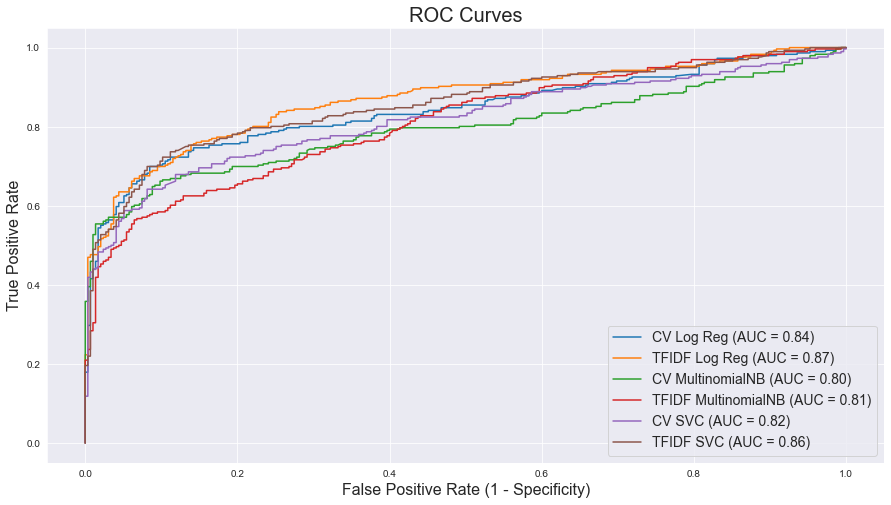

In [64]:
# plot ROC curves for all classifiers

# create a figure
fig, axes = plt.subplots(figsize=(15,8))

# ROC curve for each model
cvlr = plot_roc_curve(cvlr_gs, X_test, y_test, ax = axes, name='CV Log Reg')
tflr = plot_roc_curve(tflr_gs, X_test, y_test, ax = cvlr.ax_, name='TFIDF Log Reg')
cvnb = plot_roc_curve(cvnb_gs, X_test, y_test, ax = cvlr.ax_, name='CV MultinomialNB')
tfnb = plot_roc_curve(tfnb_gs, X_test, y_test, ax = cvlr.ax_, name='TFIDF MultinomialNB')
cvsvc = plot_roc_curve(cvsvc_gs, X_test, y_test, ax = cvlr.ax_, name='CV SVC')
tfsvc = plot_roc_curve(tfsvc_gs, X_test, y_test, ax = cvlr.ax_, name='TFIDF SVC')

# customise the plot
axes.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=16)
axes.set_ylabel('True Positive Rate', fontsize=16)
axes.set_title('ROC Curves', fontsize=20)
axes.legend(fontsize=14)

# plt.savefig('images/roc_curves.png')

## Evaluation and best model selection

Generally speaking, the Logistic Regression models performed the best, followed by Support Vector Classifiers, then Multinomial Naive Bayes.

- Logistic Regression obtained the highest average accuracy and AUC scores
- Multinomial Naive Bayes achieved the highest recall scores
- Support Vector Classifier achieved the highest precision scores

In my case, since the classes in my dataset are balanced, the metrics that I  prioritise are accuracy and AUC score. Accuracy quantifies my model's ability to make correct predictions, whereas AUC quantifies the classifier's ability to separate the two classes, regardless of the threshold value.

Given that logistic regression had the best accuracy and AUC scores, it was selected as our final model. For the vectorizers, using the TFIDF Vectorizer gives us a higher AUC score than the Count Vectorizer. Thus, the final model will be **TfidfVectorizer + Logistic Regression**.


## Explore results from TFIDF + Logistic Regression model

In [65]:
# save the best model
tflr_gs_model = tflr_gs.best_estimator_

# save the features and their corresponding coefficients
tflr_gs_features = tflr_gs_model.steps[0][1].get_feature_names()
tflr_gs_coefs = tflr_gs_model.steps[1][1].coef_.flatten()

# save the intercept of the log reg model
tflr_gs_intercept = np.exp(tflr_gs_model.steps[1][1].intercept_)

# Because these coefficients are in log-odds units, they are difficult to interpret.
# We need to convert them into odds ratios by exponentiating the coefficients
tflr_features = pd.DataFrame({'word': tflr_gs_features,
             'exp_coefficient': np.exp(tflr_gs_coefs)})\
            .sort_values('exp_coefficient', ascending=False)

In [66]:
tflr_gs_coefs

array([-0.01460633,  0.74495981,  0.11277308, ...,  0.09960091,
        0.1337073 ,  0.15593237])

In [67]:
tflr_features

,word,exp_coefficient
2473,year,13.248717
91,anyone,8.770570
982,help,7.300756
934,guy,7.139855
495,day,5.951463
...,...,...
2271,treated,0.467375
1577,partner,0.422753
1688,product,0.364929
1770,reddit,0.287913


In [68]:
tflr_gs_intercept
# if we dont have any words, it's .34 times as likely to be in the positive class (negative class)
# it doesnt make any logical sense

array([0.30142979])

In [69]:
len(tflr_gs_model.steps[0][1].vocabulary_)

2500

In [70]:
# View number of misclassifications

tn, fp, fn, tp = confusion_matrix(y_test, tflr_gs_model.predict(X_test)).ravel()

print(f'True negative: {tn}')
print(f'True positive: {tp}')
print(f'False positive: {fp}')
print(f'False negative: {fn}')

True negative: 259
True positive: 215
False positive: 36
False negative: 81


There are more posts from r/AskWomenOver30 that were wrongly predicted to be from r/AskWomen than the inverse.

In [71]:
# save the predict probabilities 
predictions = pd.DataFrame(tflr_gs_model.predict_proba(X_test), 
                           columns=['AskWomen', 'AskWomenOver30'], 
                           index=X_test.index)

In [72]:
predictions

,AskWomen,AskWomenOver30
985,0.251091,0.748909
1899,0.273120,0.726880
1067,0.083797,0.916203
973,0.729410,0.270590
1690,0.495391,0.504609
...,...,...
401,0.715166,0.284834
1304,0.280875,0.719125
1929,0.192828,0.807172
1409,0.129823,0.870177


### View the misclassified posts

In [73]:
# append predicted class 
predictions['predicted'] = tflr_gs_model.predict(X_test)

In [74]:
# append actual class
predictions['actual'] = y_test

In [75]:
predictions.sample(5)

,AskWomen,AskWomenOver30,predicted,actual
1581,0.495476,0.504524,1,1
1877,0.111976,0.888024,1,1
574,0.830462,0.169538,0,0
147,0.160101,0.839899,1,0
1622,0.551895,0.448105,0,1


In [76]:
# find all indices where predicted and true results are different and save as an array
row_ids = predictions[predictions['predicted'] != predictions['actual']].index

In [77]:
# see all posts that were wrongly classified 
wrong_preds = X_test[X_test.index.isin(row_ids)]

In [78]:
# append the text of the wrongly classified posts
predictions['text'] = wrong_preds

In [79]:
predictions

,AskWomen,AskWomenOver30,predicted,actual,text
985,0.251091,0.748909,1,1,NaN
1899,0.273120,0.726880,1,1,NaN
1067,0.083797,0.916203,1,1,NaN
973,0.729410,0.270590,0,0,NaN
1690,0.495391,0.504609,1,1,NaN
...,...,...,...,...,...
401,0.715166,0.284834,0,0,NaN
1304,0.280875,0.719125,1,1,NaN
1929,0.192828,0.807172,1,1,NaN
1409,0.129823,0.870177,1,1,NaN


In [80]:
# keep rows where predictions were wrong
predictions_wrong_df = predictions[X_test.index.isin(row_ids)]
predictions_wrong_df.sort_values('AskWomen', ascending=False)

,AskWomen,AskWomenOver30,predicted,actual,text
1119,0.788823,0.211177,0,1,decide stop playing safe work tell story
1582,0.783721,0.216279,0,1,something make instantly dislike person conver...
1275,0.779721,0.220279,0,1,reddit react teenager said ok boomer meme
1939,0.771208,0.228792,0,1,sexist thing youve known selfdescribed male fe...
1049,0.768386,0.231614,0,1,woken
...,...,...,...,...,...
372,0.332502,0.667498,1,0,ever dated someone go away certain amount time...
768,0.320320,0.679680,1,0,think love know
472,0.319343,0.680657,1,0,kind book read holiday recommendation every da...
387,0.315109,0.684891,1,0,much money need take go back last exfor month


In [81]:
predictions_wrong_df.to_clipboard(sep=',', index=False)

In [82]:
list(predictions_wrong_df['text'])

['whats best story moment first seeing blind date online dating match inperson night movie scene moment guy waiting restaurant girl walk beautiful either could could person planning meet turned lucky best story',
 'low high fabricated society example american dream marketing insurance rat race xenophobia war society expectation one another else found fabricated society',
 'lady cope pet loss putting dog tomorrow year together never expected experienced kind grief edit wow checked post today overwhelmed kindness honestly amazed still tear cry apparently thankyou everyone making feel le alone right felt many understand made feel top feeling losing member family one darkest time accountable caring gave purpose bed eventually could care ah writing helping cry situation haha taking advice many shared knowing full full love able give memory saying goodbye able given sedative injection put sleep home thankful going bury favourite place favourite tree wrote question feeling upset coworker maki

In [83]:
len(list(predictions_wrong_df['text']))

117

There were 119 out of 591 posts that were misclassified. That's 20% of all posts!

Looking at the documents that were misclassified, it seems that many of them were very short in length (less than 10 words) and and had generic content, i.e. they do not contain keywords that would allow the model to easily identify which subreddit they came from.

Let's do a quick check of the mean word count of the misclassified posts.

In [84]:
# list of word counts for the misclassified posts
word_count_misclassified = [len(x.split()) for x in list(predictions_wrong_df['text'])]

# average word count of the misclassified posts
np.mean(word_count_misclassified)

15.085470085470085

### Visualise the most predictive words

#### Bar chart – r/AskWomenOver30

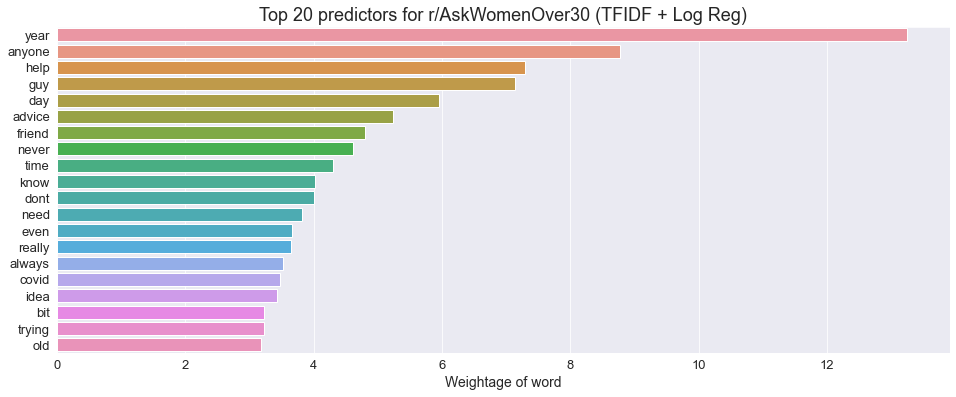

In [85]:
# visualise the top 20 features that predict the postive class
plt.figure(figsize=(16,6))
sns.barplot(x=tflr_features['exp_coefficient'][:20], y=tflr_features['word'][:20])
plt.title('Top 20 predictors for r/AskWomenOver30 (TFIDF + Log Reg)', fontsize=18)
plt.xlabel('Weightage of word', fontsize=14)
plt.xticks(size=13)
plt.ylabel(None)
plt.yticks(size=13);

In [86]:
tflr_features[:200]

,word,exp_coefficient
2473,year,13.248717
91,anyone,8.770570
982,help,7.300756
934,guy,7.139855
495,day,5.951463
...,...,...
307,cause,1.691904
421,control,1.691774
218,bf,1.688646
992,high,1.688625


In [87]:
tflr_features[-30:]

,word,exp_coefficient
2279,trope,0.663780
1938,significant,0.662642
897,good bad,0.658597
2420,whats something,0.658064
167,avoid,0.658054
343,class,0.652625
214,best way,0.651078
492,dating someone,0.648990
1359,medium,0.647255
2056,stop,0.647142


#### Word cloud – r/AskWomenOver30

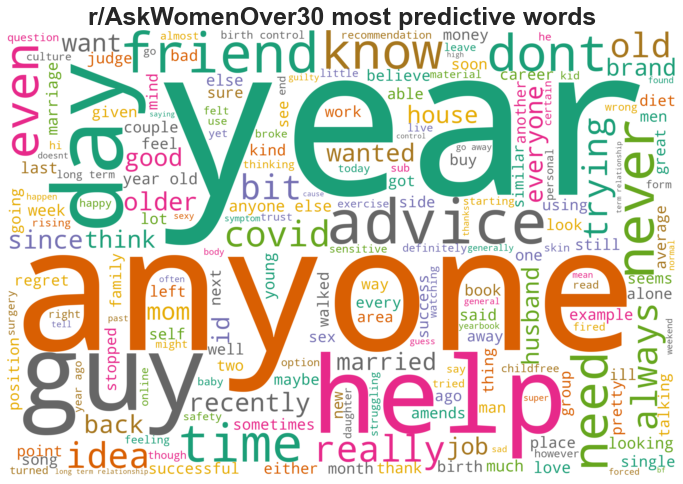

In [88]:
# words that we want to make a wordcloud for
# select the highest 300 coefficients
askwm30_wc = tflr_features[:300]

# we will generate the wordcloud using generate_from_frequencies(), which expects a dictionary as an input
# the dictionary contains the words as keys and their frequencies as values
# i will use the coefficient values as proxy for frequencies

askwm30_wc_dict = {}

for k,v in askwm30_wc.values:
    askwm30_wc_dict[k] = v

# generate wordcloud
wordcloud = WordCloud(width=3000, height=2000, 
                    background_color='white', colormap='Dark2',
                      collocations=False,
                      max_words=200,
                      ).generate_from_frequencies(askwm30_wc_dict)
plt.figure(figsize=(12,10))
plt.title('r/AskWomenOver30 most predictive words', fontsize=25, weight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
# plt.savefig('images/askwomenover30_toppreds.png')

#### Bar chart - r/AskWomen

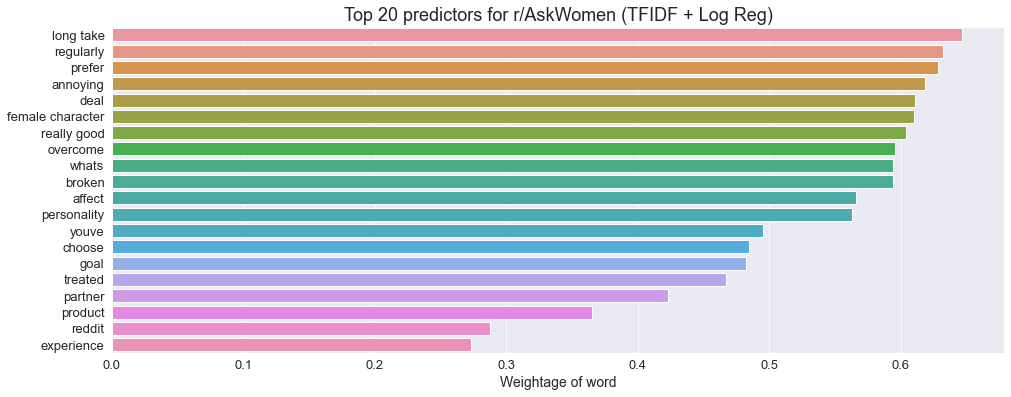

In [89]:
# visualise the top 20 features that predict the negative class
plt.figure(figsize=(16,6))
sns.barplot(x=tflr_features['exp_coefficient'][-20:], y=tflr_features['word'][-20:]) # get the bottom 20 coefficients
plt.title('Top 20 predictors for r/AskWomen (TFIDF + Log Reg)', fontsize=18)
plt.xlabel('Weightage of word', fontsize=14)
plt.xticks(size=13)
plt.ylabel(None)
plt.yticks(size=13);

#### Word cloud - r/AskWomen 

(-0.5, 2999.5, 1999.5, -0.5)

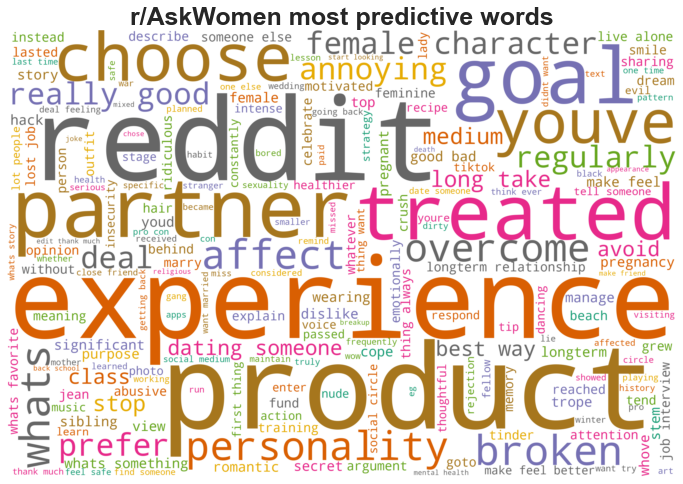

In [90]:
# words that we want to make a wordcloud for
# select the lowest 300 coefficients
askwm_wc = tflr_features[-300:]

# we will generate the wordcloud using generate_from_frequencies(), which expects a dictionary as an input
# the dictionary contains the words as keys and their frequencies as values
# i will use the coefficient values as proxy for frequencies

askwm_wc_dict = {}

for k,v in askwm_wc.values:
    askwm_wc_dict[k] = v*-1. 
    # multiply coef by -1 so that the lowest coefs will have a higher value (since they are more predictive of neg class)

# generate wordcloud
wordcloud = WordCloud(width=3000, height=2000, 
                    background_color='white', colormap='Dark2',
                      collocations=False,
                      max_words=200,
                      ).generate_from_frequencies(askwm_wc_dict)
plt.figure(figsize=(12,10))
plt.title('r/AskWomen most predictive words', fontsize=25, weight='bold')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
# plt.savefig('images/askwomen_toppreds.png')

## Conclusion

Using a TfidfVectorizer + Logistic Regression classifier trained on title and post content allowed us to classify unlabelled posts into the correct subreddit with an 80% accuracy rate. This shows that there is a distinguishable difference in most of the posts from the two subreddits, although it is hard to infer from our top predictor words that they are differentiated by age-group.

It is hard to make the generalisation that there is a clear separation in the topics discussed by women above 30, given that different people move through life at different paces and not everyone within the same age group will share the same life stage and life events. Hence, what is relevant to r/AskWomenOver30 could also be very relevant to r/AskWomen.


### Limitations and future developments

- Despite the high accuracy of the model, the most predictive words for each subreddit do not give me meaningful insight about the topics that are discussed. If I want to gain more clarity about the topics, I could try doing topic modelling instead.


- For this analysis, we only have close to 1,000 documents to train the model with. To further improve our model's accuracy, I would need more content to expand the vocabulary associated with each subreddit. Next time, I could try using the PushShift API to collect more posts to train the model with.


- The analysis was only done on the title and content of a post. What could add value to the model would be to analyse the comments as well since the two subreddits analysed are heavily discussion-based. The responses provided by the members of the respective subreddits would likely give us more insight about them as opposed to the title and post content.


- The misclassification of posts could have been partially contributed by the short length of certain posts. With fewer terms in a document, it might be harder for the model to accurately predict the correct class based on only those few words. One possible exploration to make is to filter out documents that have less than _n_ words, e.g. 10 words.


- This time round, I did lemmatization of the words, but I could also try stemming the words to see how the results would be affected.


- There is imbalance in the member count and hence activity within each subreddit. As of 8 September 2020, `AskWomenOver30` only has 79.6k members whereas `AskWomen` has 1.3m members. There could be many women over 30 who are unaware of the existence of the `AskWomenOver30` subreddit and make their posts only on the `AskWomen` subreddit, and as a result there could be many posts on the `AskWomen` subreddit that would be more appropriate for the `AskWomenOver30` subreddit instead. 


- The bag-of-words approach used does not allow for named entity recognition. Some word sequences may constitute proper names, such as the names of corporations, but these named entities will be transformed into meaningless words during the vectorization process. Next time, I could try using spaCy to do named entity recognition before vectorization.


### Final remarks

In spite of the limitations, the model performed very decently in separating the posts from the two subreddits. With more training and further fine-tuning, I believe the model can be deployed to do automatic post-sorting between r/AskWomen and r/AskWomenOver30.